In [1]:
#  经过数据增广的图片分门别类 训练集和验证集 4：1
import os,shutil,glob
import numpy as np
path_from = os.path.abspath(r'E:\gmd_data\2022062304\16cut3_Trap_Augu')	#图片原来位置的位置
path_target = os.path.abspath(r'E:\gmd_data\2022_06_23_04_Trap_Augumented\train')	#图片移动到的位置
path_target2 = os.path.abspath(r'E:\gmd_data\2022_06_23_04_Trap_Augumented\valid')	#图片移动到的位置
path_targetmodels = os.path.abspath(r'E:\gmd_data\2022_06_23_04_Trap_Augumented\models')	#图片移动到的位置
isExists = os.path.exists(path_targetmodels)
if not isExists:						# 判断如果文件不存在,则创建
    os.makedirs(path_targetmodels)       # 创建文件夹

for i in range(6408,12008,8): #这里创建626个文件夹 步进8：5nm
    # *定义一个变量判断文件是否存在,path指代路径,str(i)指代文件夹的名字*
    isExists = os.path.exists(path_target+"\\"+str(i))
    if not isExists:						# 判断如果文件不存在,则创建
        os.makedirs(path_target+"\\"+str(i))       # 创建文件夹
    isExists = os.path.exists(path_target2+"\\"+str(i))
    if not isExists:						# 判断如果文件不存在,则创建
        os.makedirs(path_target2+"\\"+str(i))       # 创建文件夹

    fns = glob.glob(path_from+'\\'+str(i)+'_'+'*.png') # 每一个高度的图片 读取一次
    # print(fns)
    for ind in range(len(fns)): # 列表中的每一张图循环一次
        dir,fn = os.path.split(fns[ind])  # 分离路径和文件名
        if ind < len(fns)*0.8:
            dstfn = path_target+'\\'+str(i)+'\\'+fn  # 生成目标目录下的新文件名
            isExists = os.path.exists(dstfn)
            if not isExists:						# 判断如果文件不存在,则创建
                shutil.copy(fns[ind],dstfn) 
                # print('ok',dstfn)
        else:
            dstfn = path_target2+'\\'+str(i)+'\\'+fn  # 生成目标目录下的新文件名
            isExists = os.path.exists(dstfn)
            if not isExists:		
                shutil.copy(fns[ind],dstfn) 
                # print('ok',dstfn)

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
%matplotlib inline


Transfer Learning for Computer Vision Tutorial
==============================================

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initialization, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.


In [4]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
image_transforms  = {
    'train': transforms.Compose([
        # transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        # transforms.RandomRotation(degrees = 45),
        # transforms.RandomHorizontalFlip(),
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# dataset = 'E:\gmd_data\microsphere2_dataAugmented'
dataset = 'E:\gmd_data\\2022_06_23_04_Trap_Augumented'
train_directory = os.path.join(dataset, 'train')
valid_directory = os.path.join(dataset, 'valid')

batch_size = 32
# num_classes = 173

data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid'])

}


train_data_size = len(data['train'])
valid_data_size = len(data['valid'])

train_data = DataLoader(data['train'], batch_size=batch_size, shuffle=True)
valid_data = DataLoader(data['valid'], batch_size=batch_size, shuffle=True)

print(train_data_size, valid_data_size)

677504 169376


迁移学习
---------


这里使用ResNet-50的预训练模型。


In [6]:
resnet50 = models.resnet50(pretrained=True)

for param in resnet50.parameters():
    param.requires_grad = True

fc_inputs = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 1300),
    nn.LogSoftmax(dim = 1)


)
resnet50 = resnet50.to('cuda:0')
loss_func = nn.NLLLoss()
# optimizer = optim.AdamW(resnet50.parameters(),lr=1e-4)

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



Epoch: 1/1
Epoch: 001, Training: Loss: 0.3930, Accuracy: 90.3586%, 
		Validation: Loss: 1.0601, Accuracy: 77.0611%, Time: 40525.3471s
Best Accuracy for validation : 0.7706 at epoch 001
Validation: MAE: 0.4931, Percentage of points retained:94.3640% 


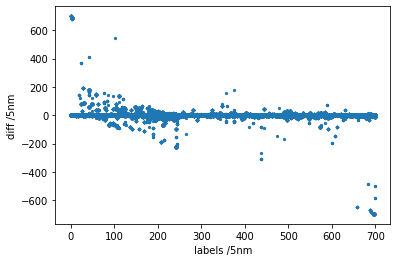

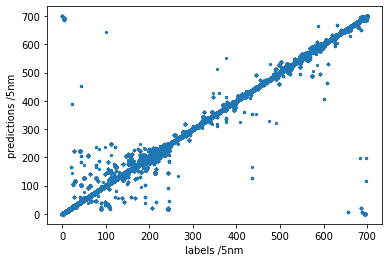

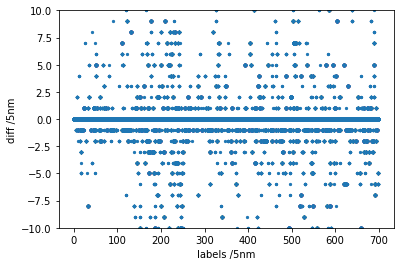

In [7]:
model = resnet50
loss_function = loss_func
epochs = 1 # 7个可能比较合适
# LR_value = 1e-4
LR_value = 1e-4
# trained_model, history = train_and_valid(resnet50, loss_func, num_epochs)
# torch.save(history, 'models/'+dataset+'_history.pt')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
history = []
best_acc = 0.0
best_epoch = 0

for epoch in range(epochs):
    epoch_start = time.time()
    print("Epoch: {}/{}".format(epoch+1, epochs))

    model.train()

    train_loss = 0.0
    train_acc = 0.0
    valid_loss = 0.0
    valid_acc = 0.0
#         学习率递减
    if epoch <= 1:
        LR = LR_value;
    elif epoch <= 2:
        LR = LR_value*0.5;
    elif epoch <= 3:
        LR = LR_value*0.5*0.5;
    elif epoch <= 4:
        LR = LR_value*0.5*0.5*0.5;
    else:
        LR = LR_value*0.5*0.5*0.5*0.5;
    optimizer = optim.AdamW(resnet50.parameters(),lr=LR)

    for i, (inputs, labels) in enumerate(train_data):
        inputs = inputs.to(device)
        labels = labels.to(device)

        #因为这里梯度是累加的，所以每次记得清零
        optimizer.zero_grad()

        outputs = model(inputs)

        loss = loss_function(outputs, labels)

        loss.backward()

        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

        ret, predictions = torch.max(outputs.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))

        acc = torch.mean(correct_counts.type(torch.FloatTensor))

        train_acc += acc.item() * inputs.size(0)

    with torch.no_grad():
        model.eval()
        predictions_all = torch.tensor([]).to(device)
        labels_all = torch.tensor([]).to(device)

        for j, (inputs, labels) in enumerate(valid_data):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            loss = loss_function(outputs, labels)

            valid_loss += loss.item() * inputs.size(0)

            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            predictions_all = torch.cat((predictions_all,predictions),dim=0)
            labels_all = torch.cat((labels_all,labels),dim=0)

            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            valid_acc += acc.item() * inputs.size(0)

    avg_train_loss = train_loss/train_data_size
    avg_train_acc = train_acc/train_data_size

    avg_valid_loss = valid_loss/valid_data_size
    avg_valid_acc = valid_acc/valid_data_size

    history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])

    if best_acc < avg_valid_acc:
        best_acc = avg_valid_acc
        best_epoch = epoch + 1

    epoch_end = time.time()

    print("Epoch: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation: Loss: {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(
        epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start
    ))
    print("Best Accuracy for validation : {:.4f} at epoch {:03d}".format(best_acc, best_epoch))

    torch.save(model, dataset+'/models/'+'model_'+str(epoch+1)+'.pt')

    diff = predictions_all - labels_all
   # conc_all = torch.cat((labels_all,predictions_all,diff),dim=0)
    device = torch.device("cpu")
    diff_small = diff[(diff>-10)&(diff<10)].to(device)
    diff_rate = len(diff_small)/len(diff)
    DIFF_MAE = np.linalg.norm(diff_small, ord = 1) / len(diff_small)
    print("Validation: MAE: {:.4f}, Percentage of points retained:{:.4f}% ".format(
        DIFF_MAE, diff_rate*100
        ))

    fig, ax = plt.subplots()
    plt.scatter(labels_all.cpu(),diff.cpu(),s=5)
    # plt.legend(['Tr Accuracy', 'Val Accuracy'])
    plt.xlabel('labels /5nm')
    plt.ylabel('diff /5nm')
    # plt.ylim(0, 1)
    # plt.savefig("C:\\Users\\nanolab115\Desktop\\"+"diff1.png")
    plt.show()
    fig.savefig('Diff_2022_06_23_04_TrapSingleAugument_16_step5_cut3DataSet.svg',dpi = 300, format = 'svg')

    fig, ax = plt.subplots()
    plt.scatter(labels_all.cpu(),predictions_all.cpu(),s=5)
    # plt.legend(['Tr Accuracy', 'Val Accuracy'])
    plt.xlabel('labels /5nm')
    plt.ylabel('predictions /5nm')
    # plt.ylim(0, 1)
    # plt.savefig("C:\\Users\\nanolab115\Desktop\\"+"diff1.png")
    plt.show()
    fig.savefig('Predictions_2022_06_23_04_TrapSingleAugument_16_step5_cut3DataSet.svg',dpi = 300, format = 'svg')

    fig, ax = plt.subplots()
    plt.scatter(labels_all.cpu(),diff.cpu(),s=5)
    # plt.legend(['Tr Accuracy', 'Val Accuracy'])
    plt.xlabel('labels /5nm')
    plt.ylabel('diff /5nm')
    plt.ylim(-10, 10)
    # plt.savefig("C:\\Users\\nanolab115\Desktop\\"+"diff1.png")
    plt.show()
    fig.savefig('Diff_small_2022_06_23_04_TrapSingleAugument_16_step5_cut3DataSet.svg',dpi = 300, format = 'svg')


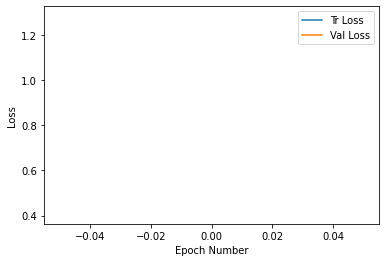

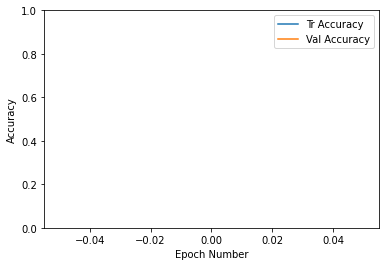

In [8]:
history = np.array(history)
plt.plot(history[:, 0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
# plt.ylim(0, 1)
plt.savefig(dataset+'_loss_curve.png')
plt.show()

plt.plot(history[:, 2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

导入模型 将验证集和真值对比图画出来
-------

In [9]:
# 导入模型 将验证集和真值对比图画出来
# dataset = 'E:\gmd_data\\2022_05_17_05_Train1_Augumented'
model38 = torch.load( dataset+'/models/'+'model_1.pt')
for param in model38.parameters():
    param.requires_grad = False
model38 = model38.to('cuda:0')
loss_function = nn.NLLLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
history = []
best_acc = 0.0
best_epoch = 0

valid_loss = 0.0
valid_acc = 0.0

predictions_all = torch.tensor([]).to(device)
labels_all = torch.tensor([]).to(device)
model38.eval()
for j, (inputs, labels) in enumerate(valid_data):
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model38(inputs)

    loss = loss_function(outputs, labels)
    # print("valid_data_j: {}".format(j))
    # print("Outputs : ")
    # print(outputs)
    # print("labels ：")
    # print(labels)
    # print("loss ：")
    # print(loss)

    valid_loss += loss.item() * inputs.size(0)

    ret, predictions = torch.max(outputs.data, 1)

    predictions_all = torch.cat((predictions_all,predictions),dim=0)
    labels_all = torch.cat((labels_all,labels),dim=0)

    correct_counts = predictions.eq(labels.data.view_as(predictions))

    acc = torch.mean(correct_counts.type(torch.FloatTensor))

    valid_acc += acc.item() * inputs.size(0)

avg_valid_loss = valid_loss/valid_data_size
avg_valid_acc = valid_acc/valid_data_size

验证集 结果：准确率、误差图像
-

Validation: Loss: 1.2830, Accuracy: 78.3251%
Validation: MAE: 0.3862, Percentage of points retained:92.0496% 


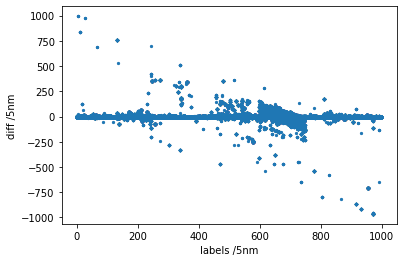

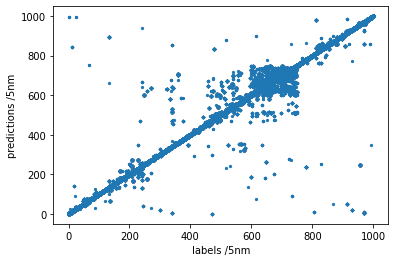

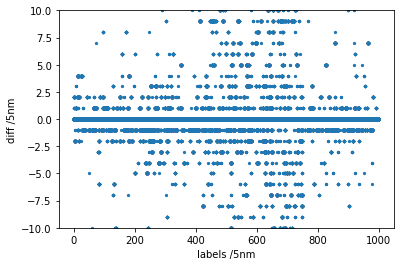

In [10]:
history.append([avg_valid_loss, avg_valid_acc])

print("Validation: Loss: {:.4f}, Accuracy: {:.4f}%".format(
    avg_valid_loss, avg_valid_acc*100
))
# print("Validation: MSE: {:.4f}".format( ))

diff = predictions_all - labels_all
# conc_all = torch.cat((labels_all,predictions_all,diff),dim=0)
device = torch.device("cpu")
diff_small = diff[(diff>-10)&(diff<10)].to(device)
diff_rate = len(diff_small)/len(diff)
DIFF_MAE = np.linalg.norm(diff_small, ord = 1) / len(diff_small)
print("Validation: MAE: {:.4f}, Percentage of points retained:{:.4f}% ".format(
    DIFF_MAE, diff_rate*100
    ))

fig, ax = plt.subplots()
plt.scatter(labels_all.cpu(),diff.cpu(),s=5)
# plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('labels /5nm')
plt.ylabel('diff /5nm')
# plt.ylim(0, 1)
# plt.savefig("C:\\Users\\nanolab115\Desktop\\"+"diff1.png")
plt.show()
fig.savefig('Diff_2022_06_23_01_Train2SingleAugument_16_step5_cut3DataSet.svg',dpi = 300, format = 'svg')

fig, ax = plt.subplots()
plt.scatter(labels_all.cpu(),predictions_all.cpu(),s=5)
# plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('labels /5nm')
plt.ylabel('predictions /5nm')
# plt.ylim(0, 1)
# plt.savefig("C:\\Users\\nanolab115\Desktop\\"+"diff1.png")
plt.show()
fig.savefig('Predictions_2022_06_23_01_Train2SingleAugument_16_step5_cut3DataSet.svg',dpi = 300, format = 'svg')

fig, ax = plt.subplots()
plt.scatter(labels_all.cpu(),diff.cpu(),s=5)
# plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('labels /5nm')
plt.ylabel('diff /5nm')
plt.ylim(-10, 10)
# plt.savefig("C:\\Users\\nanolab115\Desktop\\"+"diff1.png")
plt.show()
fig.savefig('Diff_small_2022_06_23_01_Train2SingleAugument_16_step5_cut3DataSet.svg',dpi = 300, format = 'svg')

测试组：用未训练的 0104-2组 进行测试
-

Validation: valid_data_size: 1060.0000
Validation: Loss: 931.1895, Accuracy: 0.0000%


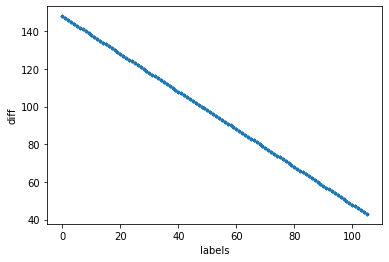

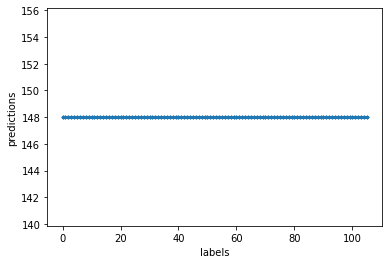

In [11]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

# Data augmentation and normalization for training
# Just normalization for validation
image_transforms  = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees = 45),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# dataset = 'E:\gmd_data\microsphere2_dataAugmented'
dataset = 'E:\gmd_data\GMD_0104_2_DATA' # 测试集 0104-2
# dataset = 'E:\gmd_data\GMD_0104_3_DATA' # 测试集 0104-3
# dataset = 'E:\gmd_data\\fangdai_MixTest' # 防呆测试 0104-2-3混合
# dataset = 'E:\gmd_data\GMD_0104_2_DATA_TEST' # 测试集 0104-2 50-8650 照明测试

# train_directory = os.path.join(dataset, 'train')
valid_directory = os.path.join(dataset, 'valid')

batch_size = 32
# num_classes = 173
# class Datset():
#     def __getitem(self,index):
        
#         return image_torch
#     def __len__(self):
#         pass

# data = {
#     # 'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
#     'valid':Datset(root=valid_directory, transform=image_transforms['valid'])

# }
data = {
    # 'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid'])

}



# train_data_size = len(data['train'])
valid_data_size = len(data['valid'])

# train_data = DataLoader(data['train'], batch_size=batch_size, shuffle=True)
valid_data = DataLoader(data['valid'], batch_size=batch_size, shuffle=True)

print("Validation: valid_data_size: {:.4f}".format(
    valid_data_size
))


# 导入模型 将验证集和真值对比图画出来
dataset = 'E:\gmd_data\microsphere2_dataAugmented'
model38 = torch.load( dataset+'/models/'+'model_38.pt')
for param in model38.parameters():
    param.requires_grad = False
model38 = model38.to('cuda:0')
loss_function = nn.NLLLoss()



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
history = []
best_acc = 0.0
best_epoch = 0


valid_loss = 0.0
valid_acc = 0.0

predictions_all = torch.tensor([]).to(device)
labels_all = torch.tensor([]).to(device)

with torch.no_grad():
    model38.eval()
    for j, (inputs, labels) in enumerate(valid_data):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model38(inputs)

        loss = loss_function(outputs, labels)
        # print("valid_data_j: {}".format(j))
        # print("Outputs : ")
        # print(outputs)
        # print("labels ：")
        # print(labels)
        # print("loss ：")
        # print(loss)

        valid_loss += loss.item() * inputs.size(0)

        ret, predictions = torch.max(outputs.data, 1)

        predictions_all = torch.cat((predictions_all,predictions),dim=0)
        labels_all = torch.cat((labels_all,labels),dim=0)

        correct_counts = predictions.eq(labels.data.view_as(predictions))

        acc = torch.mean(correct_counts.type(torch.FloatTensor))

        valid_acc += acc.item() * inputs.size(0)

avg_valid_loss = valid_loss/valid_data_size
avg_valid_acc = valid_acc/valid_data_size

avg_valid_loss = valid_loss/valid_data_size
avg_valid_acc = valid_acc/valid_data_size

# plot
history.append([avg_valid_loss, avg_valid_acc])

print("Validation: Loss: {:.4f}, Accuracy: {:.4f}%".format(
    avg_valid_loss, avg_valid_acc*100
))
# print("Validation: MSE: {:.4f}".format( ))

diff = predictions_all - labels_all
conc_all = torch.cat((labels_all,predictions_all,diff),dim=0)

plt.scatter(labels_all[0:50000].cpu(),diff[0:50000].cpu(),s=5)
# plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('labels')
plt.ylabel('diff')
# plt.ylim(0, 1)
# plt.savefig("C:\\Users\\nanolab115\Desktop\\"+"diff1.png")
plt.show()

plt.scatter(labels_all.cpu(),predictions_all.cpu(),s=5)
# plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('labels')
plt.ylabel('predictions')
# plt.ylim(0, 1)
# plt.savefig("C:\\Users\\nanolab115\Desktop\\"+"diff1.png")
plt.show()

Test Command
------


In [12]:
value,num = torch.max(outputs, 1)
print("num:",num,"value:",value)


num: tensor([148, 148, 148, 148], device='cuda:0') value: tensor([0., 0., 0., 0.], device='cuda:0')


In [13]:
print("outputs:",outputs)

outputs1 = torch.cat((outputs,outputs),dim=0)
print("outputs1:",outputs1)

value,num = torch.max(outputs1, 1)
print("num:",num,"value:",value)


outputs: tensor([[ -351.2668,  -973.8725,  -764.9099,  -640.0015,  -504.9979,  -454.4819,
          -339.5540,  -266.9993,  -219.8134,  -303.4277,  -438.5500,  -195.6255,
          -681.2841,  -824.3527, -1090.5336, -1201.3979, -1183.9504, -1310.7225,
         -1287.2673, -1280.6128, -1260.8097, -1222.4388,  -308.9716, -1314.4506,
         -1252.1018, -1574.3258, -1564.3737, -1574.4531, -1327.0447, -1284.4587,
          -926.1189,  -745.0117,  -576.5895,  -229.7789,  -396.6804,  -472.3846,
          -514.8936,  -744.8950,  -865.6696,  -871.2866, -1046.7197, -1324.6970,
         -1603.0510, -1620.7592,  -367.9890, -1387.1034, -1256.1277, -1135.6356,
         -1052.8574, -1081.2194, -1029.6642, -1081.0746,  -981.6948, -1060.3214,
         -1196.7916,  -620.9381, -1127.5012, -1124.9696,  -984.3215,  -800.0749,
          -389.3513,  -252.8829,  -432.3701,  -561.2480,  -657.8389,  -924.4231,
          -489.4842,  -820.3997,  -812.8976, -1054.9248, -1230.9481, -1173.0333,
          -943.5822

In [14]:
num2 = torch.tensor([]).to(device)
num1 = torch.cat((num2,num),dim=0)

In [15]:
print('C:\\Users\\nanolab115\Desktop\\'+'diff1.png')

C:\Users\nanolab115\Desktop\diff1.png


In [16]:
pip install pygal
